In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cpymad.madx import Madx
from pybt.tools.plotters import *
from madxtools.plot_tool import *
import requests
from madxtools.air_scattering import *
# import ipywidgets as widgets
# from ipywidgets import *
from IPython.display import display

In [3]:
nominal_optics = [
    0.479688,
    0.21,
    0.19864,
    0.090343,
    0.195989,
    0.194437,
    0.061494,
    0.069052,
]

In [4]:
small_optics = [
    0.516791,
    0.092191,
    0.159852,
    0.08921,
    0.156452,
    0.13073,
    0.053997,
    0.098982,
]

In [5]:
large_optics = [
    0.453482,
    0.10264,
    0.212974,
    0.100192,
    0.214876,
    0.208812,
    0.016889,
    0.031995,
]

In [6]:
E_cin_per_nucleon = 2.0
# Ion properties
A = 208.0
Z = 82.0
N = 126.0
charge = 54.0
m_proton_GeV = 0.93828
m_neutron_GeV = 0.93957
m_electron_GeV = 0.000511
m_u_GeV = 0.9315
mass_defect_GeV = Z * m_proton_GeV + N * m_neutron_GeV + (Z - charge) * m_electron_GeV - A * m_u_GeV
E_0 = Z * m_proton_GeV + N * m_neutron_GeV - mass_defect_GeV

p = E_0 * np.sqrt((((E_cin_per_nucleon * A) / E_0) + 1) ** 2 - 1)

gamma = p/charge/0.938
beta = np.sqrt(1-gamma**(-2))
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

print(p/charge)
print(f"gamma = {round(gamma,3)}")
print(f"beta = {round(beta,3)}")
print(f"p = {round(p/charge,3)} GeV/c")

Brho = 3.33564*p/charge

10.706294697042374
gamma = 11.414
beta = 0.996
p = 10.706 GeV/c


ex = 2.23e-06
ey = 6.10e-07


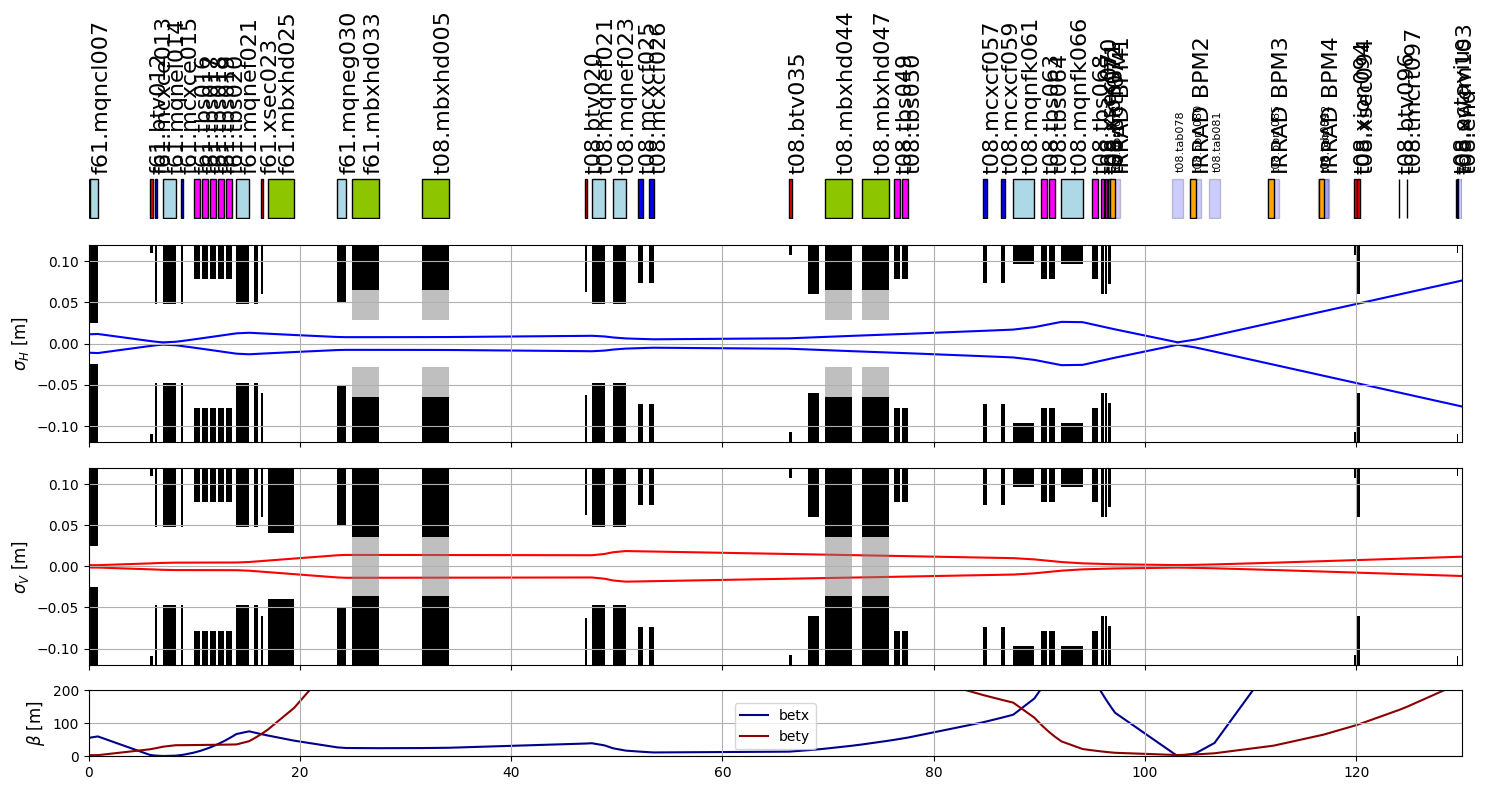

In [13]:
# Matched initial parameters 13nd oct 2023
betx0 = 53.074
alfx0 = -13.191
dx0 = 0.13
dpx0 = 0.02
exn = 2.53e-5

bety0 = 3.675
alfy0 = 0.859
dy0 = 0.0
dpy0 = 0.0
eyn = 6.94e-06

sige = 0.0045

ex = exn/(beta*gamma)
ex_initial = ex
print(f"ex = {ex_initial:.2e}")
ey = eyn/(beta*gamma)
ey_initial = ey
print(f"ey = {ey_initial:.2e}")

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.str").text)
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.seq").text)

# Optics
optics = small_optics
madx.input("kQFN1 = "+str(optics[0])+";")
madx.input("kQDN2 = "+str(-optics[1])+";")
madx.input("kQFN3 = "+str(optics[2])+";")
madx.input("kQDN4 = "+str(-optics[3])+";")
madx.input("kQFN5 = "+str(optics[4])+";")
madx.input("kQDN6 = "+str(-optics[5])+";")
madx.input("kQDN7 = "+str(-optics[6])+";")
madx.input("kQFN8 = "+str(optics[7])+";")

madx.input('''
/***************************** Dipoles ******************************/ 
kBHZ1 = -0.04821227494;
kBHZ2 = 0.04980753404;
kBHZ3 = 0.02555487086;
kBHZ4 = -0.03515967369;
kBHZ5 = -0.03515967369;
''')

# Add the Air region
sequence = "f61t8_op"

madx.input('''
SEQEDIT, sequence=f61t8_op;
SELECT, FLAG = SEQEDIT, PATTERN = "^t08.vaccu*";
REMOVE, ELEMENT=SELECTED;
ENDEDIT;
''')

madx.command.beam(particle='PROTON',pc=p/charge,exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,ANGLE,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madx.use(sequence=sequence)

# make thin
madx.use(sequence="f61t8_op")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')
madx.use(sequence="f61t8_op")
madx.input("SELECT, FLAG=makethin, CLASS=dipole, SLICE=3;")
# madx.input("MAKETHIN, SEQUENCE=f61t8_op, style=TEAPOT")
madx.use(sequence="f61t8_op")


twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0, file = "twiss_f61t8_2GeV_Pb_small_beam_2024.tfs").dframe()
plot_graph(twiss, ex, sige, ey, fontsize=12, figsize=(15,8), height_ratios=[1,3,3,1])


/var/folders/8q/l42hhsl13fxd0py0_2dw6k900000gn/T/ipykernel_86203/167769523.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0].set_xlim(0,twiss.s[-1])
/var/folders/8q/l42hhsl13fxd0py0_2dw6k900000gn/T/ipykernel_86203/167769523.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[1].set_xlim(0,twiss.s[-1])
/var/folders/8q/l42hhsl13fxd0py0_2dw6k900000gn/T/ipykernel_86203/167769523.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

Text(0.5, 0.98, 'Ion small beam on IRRAD table 1')

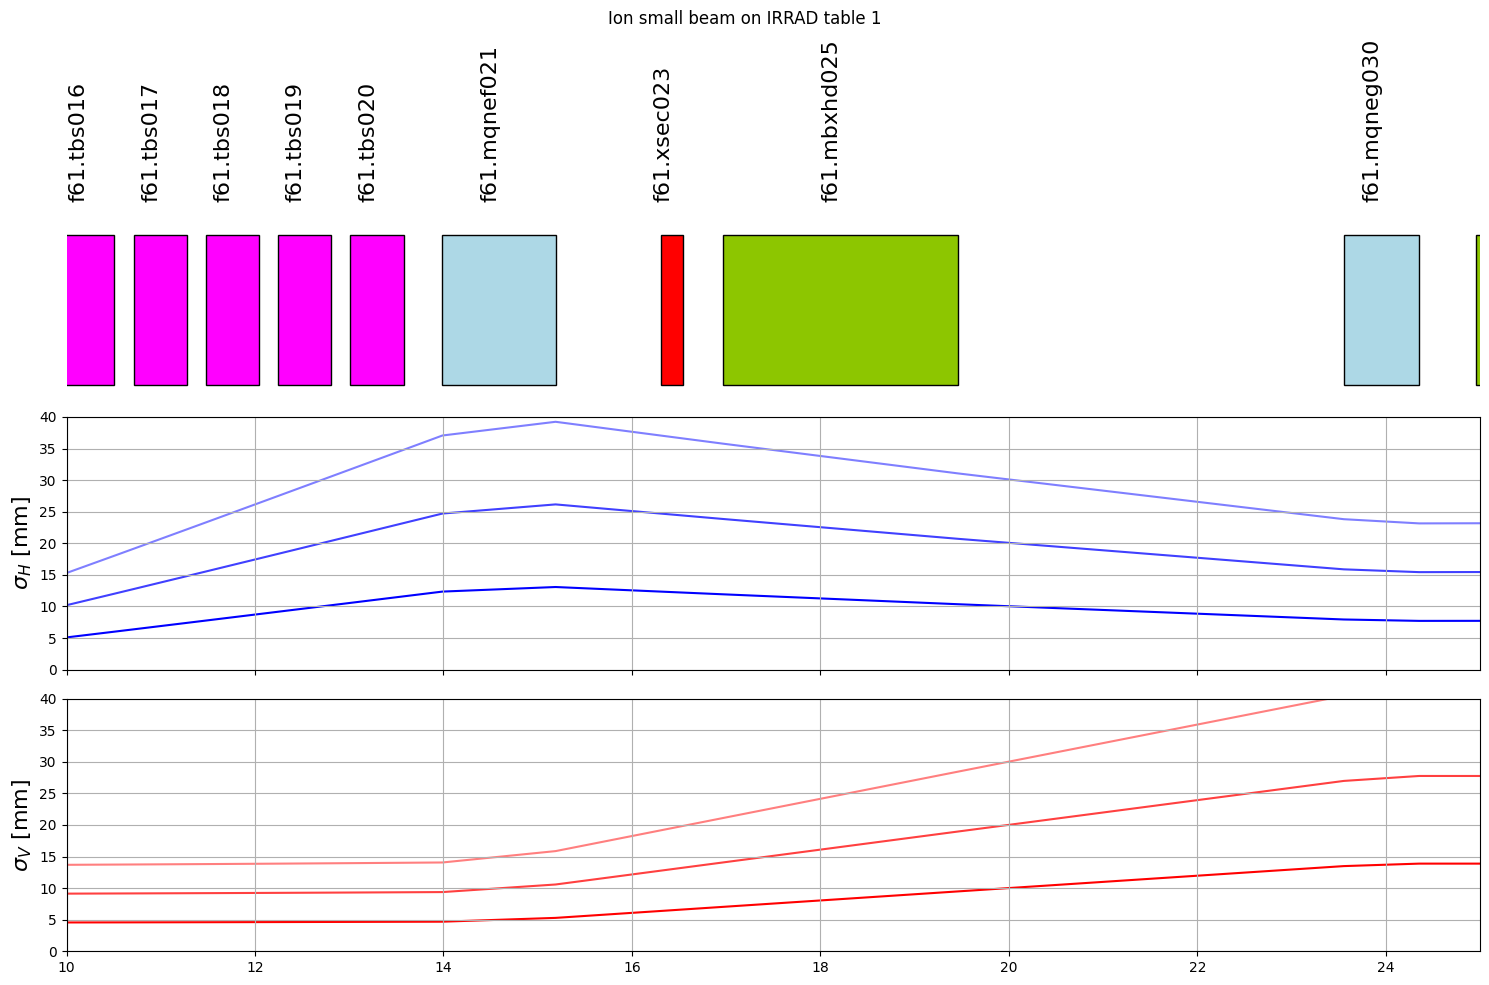

In [14]:
fontsize = 16

fig, ax = plt.subplots(3,1, figsize=(15,10), tight_layout=True, sharex=True)

draw_synoptic(ax[0], twiss)
ax[0].set_xlim(0,twiss.s[-1])
ax[0].set_ylim(-0.01,1.)
ax[0].axis("off")

ax[1].plot(twiss['s'], beam_size(twiss['betx'], twiss['dx'], ex, sige, 1)*1000, alpha=1.0, color ="b", zorder=0)
ax[1].plot(twiss['s'], -beam_size(twiss['betx'], twiss['dx'], ex, sige, 1)*1000, alpha=1.0, color ="b", zorder=0)

ax[1].plot(twiss['s'], beam_size(twiss['betx'], twiss['dx'], ex, sige, 2)*1000, alpha=0.75, color ="b", zorder=0)
ax[1].plot(twiss['s'], -beam_size(twiss['betx'], twiss['dx'], ex, sige, 2)*1000, alpha=0.75, color ="b", zorder=0)

ax[1].plot(twiss['s'], beam_size(twiss['betx'], twiss['dx'], ex, sige, 3)*1000, alpha=0.5, color ="b", zorder=0)
ax[1].plot(twiss['s'], -beam_size(twiss['betx'], twiss['dx'], ex, sige, 3)*1000, alpha=0.5, color ="b", zorder=0)

# draw_aperture(ax[1], twiss, "aper_1")
ax[1].set_xlim(0,twiss.s[-1])

ax[2].plot(twiss['s'], beam_size(twiss['bety'], twiss['dy'], ey, sige, 1)*1000, alpha=1.0, color ="r", zorder=0)
ax[2].plot(twiss['s'], -beam_size(twiss['bety'], twiss['dy'], ey, sige, 1)*1000, alpha=1.0, color ="r", zorder=0)

ax[2].plot(twiss['s'], beam_size(twiss['bety'], twiss['dy'], ey, sige, 2)*1000, alpha=0.75, color ="r", zorder=0)
ax[2].plot(twiss['s'], -beam_size(twiss['bety'], twiss['dy'], ey, sige, 2)*1000, alpha=0.75, color ="r", zorder=0)

ax[2].plot(twiss['s'], beam_size(twiss['bety'], twiss['dy'], ey, sige, 3)*1000, alpha=0.5, color ="r", zorder=0)
ax[2].plot(twiss['s'], -beam_size(twiss['bety'], twiss['dy'], ey, sige, 3)*1000, alpha=0.5, color ="r", zorder=0)

# draw_aperture(ax[1], twiss, "aper_2")
ax[2].set_xlim(0,twiss.s[-1])

ax[1].grid()
ax[1].set_ylim(0, 40)
ax[1].set_ylabel(r"$\sigma_{H}$ [mm]", fontsize=fontsize)

ax[2].grid()
ax[2].set_ylim(0, 40)
ax[2].set_ylabel(r"$\sigma_{V}$ [mm]", fontsize=fontsize)

ax[1].set_xlim(10, 25)

fig.suptitle("Ion small beam on IRRAD table 1")

# Large optics

ex = 2.23e-06
ey = 6.10e-07


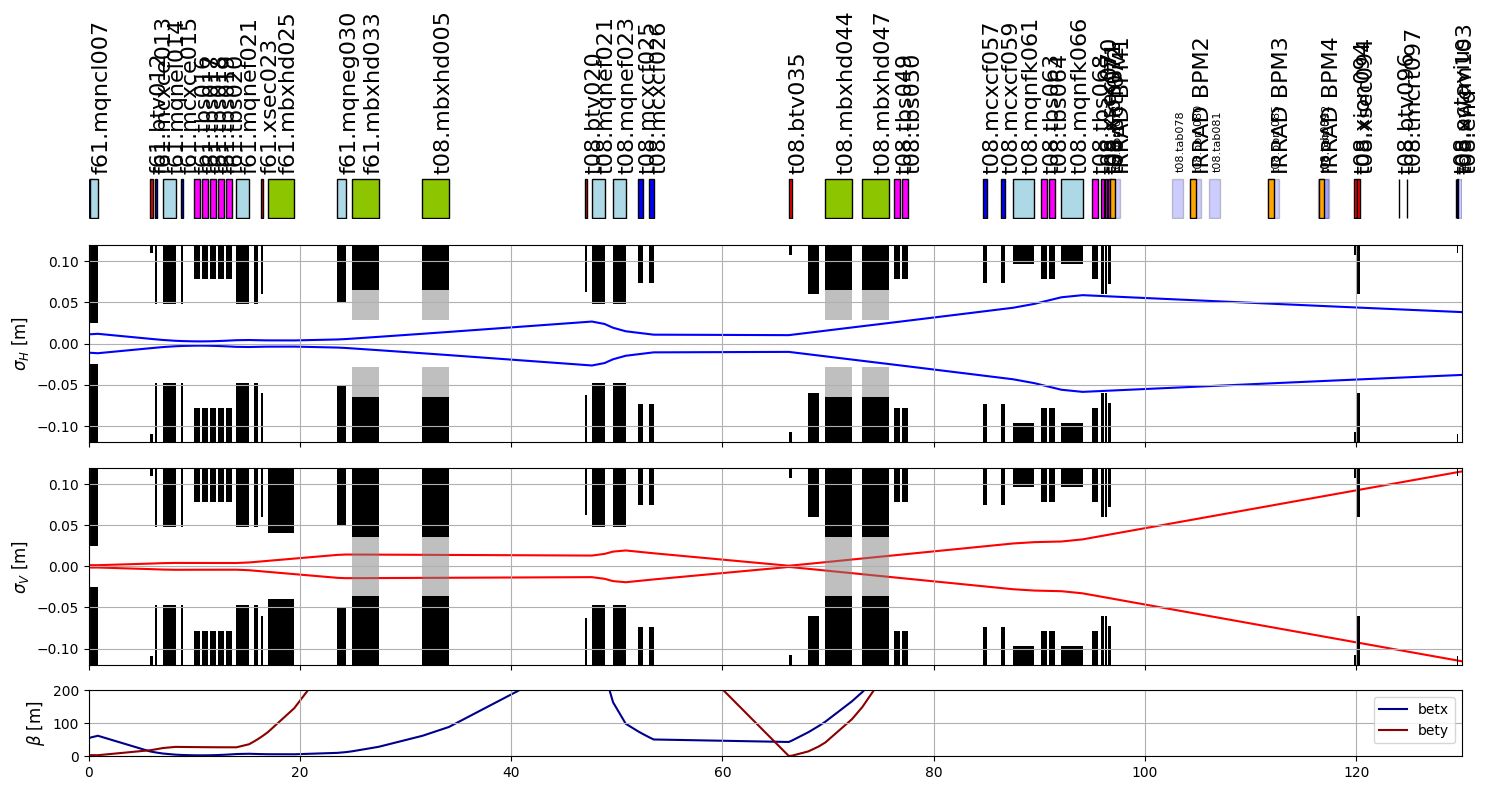

In [9]:
# Matched initial parameters 13nd oct 2023
betx0 = 53.074
alfx0 = -13.191
dx0 = 0.13
dpx0 = 0.02
exn = 2.53e-5

bety0 = 3.675
alfy0 = 0.859
dy0 = 0.0
dpy0 = 0.0
eyn = 6.94e-06

sige = 0.0045

ex = exn/(beta*gamma)
ex_initial = ex
print(f"ex = {ex_initial:.2e}")
ey = eyn/(beta*gamma)
ey_initial = ey
print(f"ey = {ey_initial:.2e}")

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.str").text)
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.seq").text)

# Optics
optics = large_optics
madx.input("kQFN1 = "+str(optics[0])+";")
madx.input("kQDN2 = "+str(-optics[1])+";")
madx.input("kQFN3 = "+str(optics[2])+";")
madx.input("kQDN4 = "+str(-optics[3])+";")
madx.input("kQFN5 = "+str(optics[4])+";")
madx.input("kQDN6 = "+str(-optics[5])+";")
madx.input("kQDN7 = "+str(-optics[6])+";")
madx.input("kQFN8 = "+str(optics[7])+";")

madx.input('''
/***************************** Dipoles ******************************/ 
kBHZ1 = -0.04821227494;
kBHZ2 = 0.04980753404;
kBHZ3 = 0.02555487086;
kBHZ4 = -0.03515967369;
kBHZ5 = -0.03515967369;
''')

# Add the Air region
sequence = "f61t8_op"

madx.input('''
SEQEDIT, sequence=f61t8_op;
SELECT, FLAG = SEQEDIT, PATTERN = "^t08.vaccu*";
REMOVE, ELEMENT=SELECTED;
ENDEDIT;
''')

madx.command.beam(particle='PROTON',pc=p/charge,exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,ANGLE,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madx.use(sequence=sequence)

# make thin
madx.use(sequence="f61t8_op")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')
madx.use(sequence="f61t8_op")
madx.input("SELECT, FLAG=makethin, CLASS=dipole, SLICE=3;")
# madx.input("MAKETHIN, SEQUENCE=f61t8_op, style=TEAPOT")
madx.use(sequence="f61t8_op")


twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0, file = "twiss_f61t8_2GeV_Pb_large_beam_2024.tfs").dframe()
plot_graph(twiss, ex, sige, ey, fontsize=12, figsize=(15,8), height_ratios=[1,3,3,1])


/var/folders/8q/l42hhsl13fxd0py0_2dw6k900000gn/T/ipykernel_86203/167769523.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0].set_xlim(0,twiss.s[-1])
/var/folders/8q/l42hhsl13fxd0py0_2dw6k900000gn/T/ipykernel_86203/167769523.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[1].set_xlim(0,twiss.s[-1])
/var/folders/8q/l42hhsl13fxd0py0_2dw6k900000gn/T/ipykernel_86203/167769523.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

Text(0.5, 0.98, 'Ion small beam on IRRAD table 1')

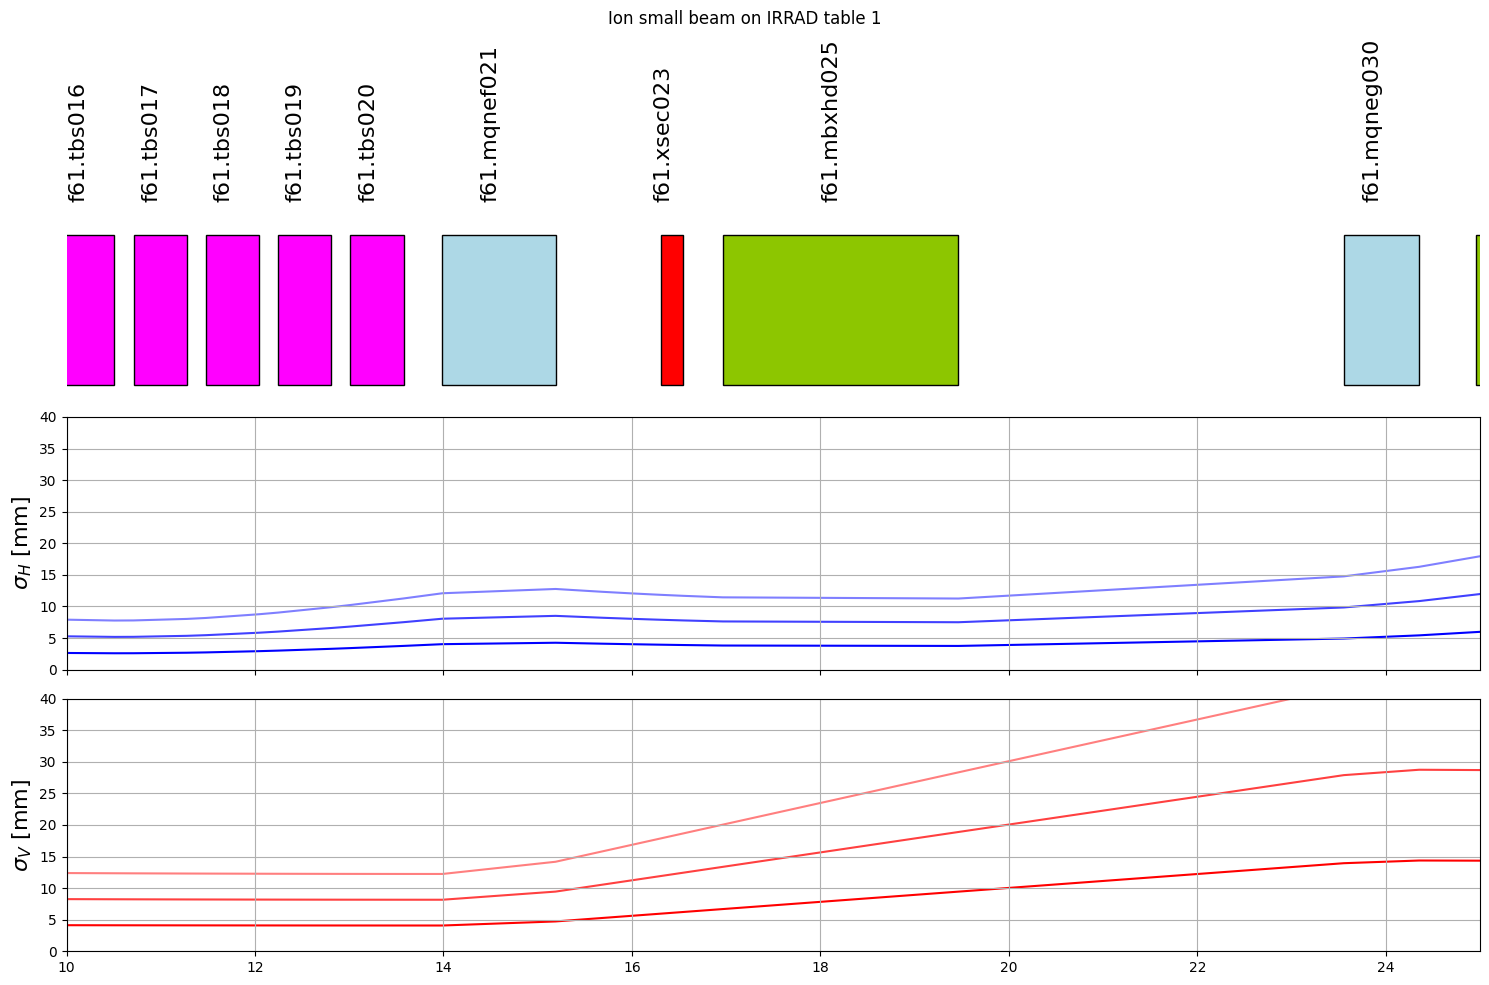

In [10]:
fontsize = 16

fig, ax = plt.subplots(3,1, figsize=(15,10), tight_layout=True, sharex=True)

draw_synoptic(ax[0], twiss)
ax[0].set_xlim(0,twiss.s[-1])
ax[0].set_ylim(-0.01,1.)
ax[0].axis("off")

ax[1].plot(twiss['s'], beam_size(twiss['betx'], twiss['dx'], ex, sige, 1)*1000, alpha=1.0, color ="b", zorder=0)
ax[1].plot(twiss['s'], -beam_size(twiss['betx'], twiss['dx'], ex, sige, 1)*1000, alpha=1.0, color ="b", zorder=0)

ax[1].plot(twiss['s'], beam_size(twiss['betx'], twiss['dx'], ex, sige, 2)*1000, alpha=0.75, color ="b", zorder=0)
ax[1].plot(twiss['s'], -beam_size(twiss['betx'], twiss['dx'], ex, sige, 2)*1000, alpha=0.75, color ="b", zorder=0)

ax[1].plot(twiss['s'], beam_size(twiss['betx'], twiss['dx'], ex, sige, 3)*1000, alpha=0.5, color ="b", zorder=0)
ax[1].plot(twiss['s'], -beam_size(twiss['betx'], twiss['dx'], ex, sige, 3)*1000, alpha=0.5, color ="b", zorder=0)

# draw_aperture(ax[1], twiss, "aper_1")
ax[1].set_xlim(0,twiss.s[-1])

ax[2].plot(twiss['s'], beam_size(twiss['bety'], twiss['dy'], ey, sige, 1)*1000, alpha=1.0, color ="r", zorder=0)
ax[2].plot(twiss['s'], -beam_size(twiss['bety'], twiss['dy'], ey, sige, 1)*1000, alpha=1.0, color ="r", zorder=0)

ax[2].plot(twiss['s'], beam_size(twiss['bety'], twiss['dy'], ey, sige, 2)*1000, alpha=0.75, color ="r", zorder=0)
ax[2].plot(twiss['s'], -beam_size(twiss['bety'], twiss['dy'], ey, sige, 2)*1000, alpha=0.75, color ="r", zorder=0)

ax[2].plot(twiss['s'], beam_size(twiss['bety'], twiss['dy'], ey, sige, 3)*1000, alpha=0.5, color ="r", zorder=0)
ax[2].plot(twiss['s'], -beam_size(twiss['bety'], twiss['dy'], ey, sige, 3)*1000, alpha=0.5, color ="r", zorder=0)

# draw_aperture(ax[1], twiss, "aper_2")
ax[2].set_xlim(0,twiss.s[-1])

ax[1].grid()
ax[1].set_ylim(0, 40)
ax[1].set_ylabel(r"$\sigma_{H}$ [mm]", fontsize=fontsize)

ax[2].grid()
ax[2].set_ylim(0, 40)
ax[2].set_ylabel(r"$\sigma_{V}$ [mm]", fontsize=fontsize)

ax[1].set_xlim(10, 25)

fig.suptitle("Ion small beam on IRRAD table 1")